<a href="https://colab.research.google.com/github/obliquesignal/algo-trading-bootcamp/blob/master/Probabilistic_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import relevant Python libraries
import numpy as np
import pandas as pd
from datetime import datetime
import xarray as xr

import matplotlib.pyplot as plt
plt.style.use('seaborn')

#Install and import PyMC and Arviz libraries
!pip install pymc -q
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

#Install and import Yahoo Finance web scraper
!pip install yfinance -q
import yfinance as yf

<ipython-input-1-3cfb7cb8582e>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
RANDOM_SEED = 101
rng = np.random.default_rng(RANDOM_SEED)

In [ ]:
#Import financial data
start = datetime(2022, 11, 15)
end = datetime(2022, 12, 31)
 
#S&P 500 index is a proxy for the market
market = yf.Ticker('SPY').history(start=start, end=end)
#Ticker symbol for Apple, the largest company in the world by market capitalization
stock = yf.Ticker('AAPL').history(start=start, end=end)
#10 year US treasury note is the proxy for risk free rate
riskfree_rate = yf.Ticker('^TNX').history(start=start, end=end)

#Create dataframe to hold daily returns of securities
daily_returns = pd.DataFrame()
#Compute daily percentage returns based on closing prices for Apple and S&P 500 index
daily_returns['market'] = market['Close'].pct_change(1)*100
daily_returns['stock'] = stock['Close'].pct_change(1)*100
#Compounded daily rate based on 360 days for the calendar year used in the bond market
daily_returns['riskfree'] = (1 + riskfree_rate['Close']) ** (1/360) - 1

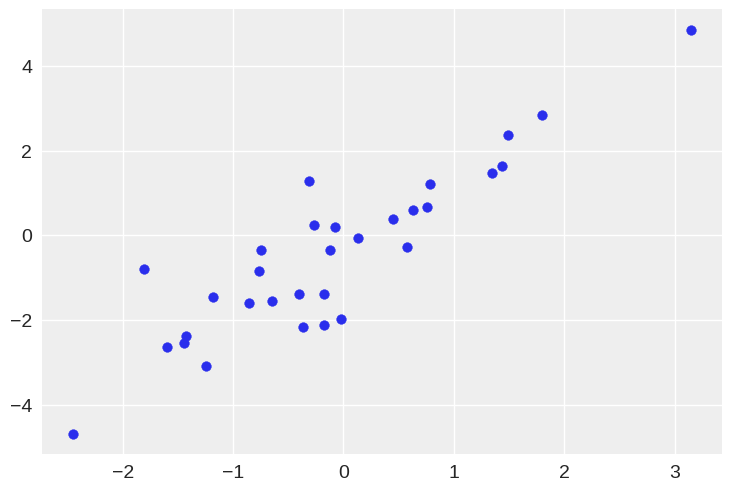

In [ ]:
#Check for missing rows in the dataframe
market.index.difference(riskfree_rate.index)
#Fill rows with previous day's risk-free rate since daily rates are generally stable
daily_returns = daily_returns.ffill()
#Drop NaNs in first row because of percentage calculations are based on previous day's closing price
daily_returns = daily_returns.dropna()
#Check dataframe for null values
daily_returns.isnull().sum()
#Check first five rows of dataframe
daily_returns.head()
 
#Daily excess returns of AAPL are returns in excess of the daily risk free rate
y = daily_returns['stock'] - daily_returns['riskfree']
#Daily excess returns of the market are returns in excess of the daily risk free rate
x = daily_returns['market'] - daily_returns['riskfree']

#Plot the data
plt.scatter(x,y);

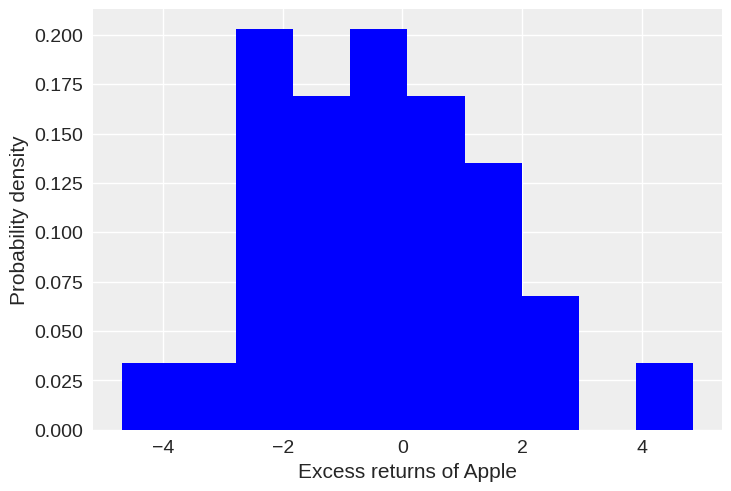

In [ ]:
#Plot histogram of Apple's excess returns during the period
plt.hist(y, density=True, color='blue')
plt.ylabel('Probability density'), plt.xlabel('Excess returns of Apple');

In [ ]:
#Analyze daily returns of all securities
daily_returns.describe()

,market,stock,riskfree
count,31.000000,31.000000,31.000000
mean,-0.110989,-0.444417,0.004282
std,1.192475,1.967499,0.000083
min,-2.446174,-4.685430,0.004129
25%,-0.805421,-1.775163,0.004200
50%,-0.171748,-0.343505,0.004299
75%,0.602694,0.635443,0.004340
max,3.150058,4.859395,0.004417


In [ ]:
#Use a time series split because of serial correlation in financial time series data
test_size = 10

x_train = x[:-test_size]
y_train = y[:-test_size]

x_test = x[-test_size:]
y_test = y[-test_size:]

In [ ]:
#We create our probabilistic model by instantiating the PyMC model class
model = pm.Model()

#The with statement creates a context manager for our model object. 
#All variables and constants inside the with-block are part of our model.

with model:
  #Define the prior probability distributions of our model parameters 
  
  #Assume that alpha is normally distributed. The values of mu and sigma are based on previous data analysis and guesses.
  #Alpha is the idiosyncratic, daily excess return of Apple unaffected by market movements.
  alpha = pm.Normal('alpha', mu=0.02, sigma=0.10)
  
  #Assume that beta is also normally distributed. The values of mu and sigma are based on previous data analysis and guesses.
  #Beta quantifies the sensitivity of Apple to the movements of the market/S&P 500.
  beta = pm.Normal('beta', mu=1.2, sigma=0.15)

  #We assume residuals are Half Student T distributed with nu=6.
  #Residual quantifies the unexpected returns of Apple i.e returns not predicted by the linear model.
  residual = pm.HalfStudentT('residual', sigma=0.20, nu=6)
  #residual = pm.HalfNormal('residual', sigma=0.5)

  #Data containers are used so that we can swap out training data for test data later
  feature = pm.MutableData('feature', x_train)
  target = pm.MutableData('target', y_train)

  #Expected daily excess returns of Apple are approximately linearly related to daily excess returns of S&P 500
  #The function below specifies the linear relationship to give us a regression line
  target_mean = alpha + beta * feature

  #Daily excess stock price returns are assumed to be T-distributed with nu=6.
  #Assign the training data sample to the likelihood function.   
  target_observed = pm.StudentT('target_observed', mu=target_mean, sigma=residual, nu=6, observed=target)
  #target_observed = pm.Normal('target_observed', mu=target_mean, sigma=residual, observed=target)

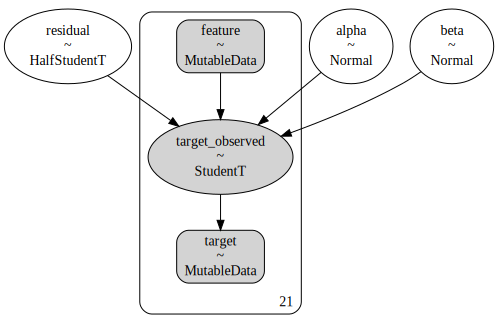

In [ ]:
#Use the graphviz method to visualize our probabilistic model's data, parameters, distributions and dependencies
pm.model_to_graphviz(model)

In [ ]:
#We can sample from our prior parameter distributions and the likelihood functions to generate checks on our model
#Take 1000 draws from the prior predictive distribution to simulate (1000*21) target values based on our prior assumptions
idata = pm.sample_prior_predictive(samples=1000, model=model, return_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
#PyMC/Arviz returns an xarray - a labeled, multidimensional array containing inference data sets structured into groups
#Note the dimensions of the prior predictive group to see how we got (1*1000*21) simulated target values
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

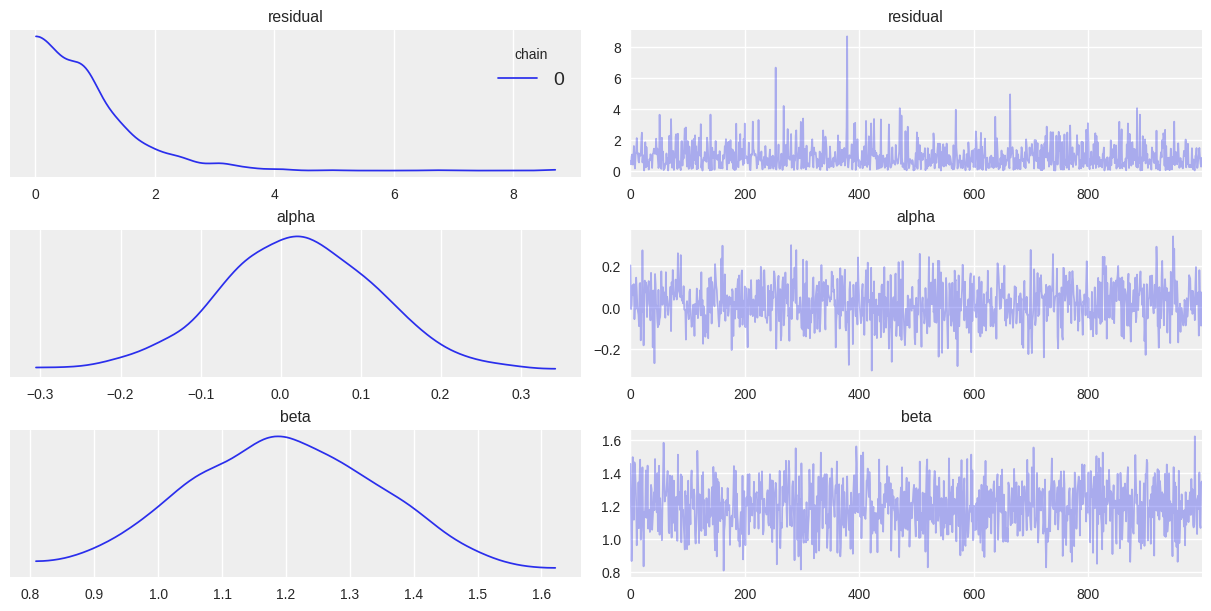

In [ ]:
#Subplots on the left show the kernel density estimates (KDE) of the marginal prior probability distributions of our parameters from the 1000 samples drawn 
#The subplots on the right show the actual parameter values from a single chain that were sampled sequentially by the PyMC sampler
az.plot_trace(idata.prior, kind='trace', legend=True);

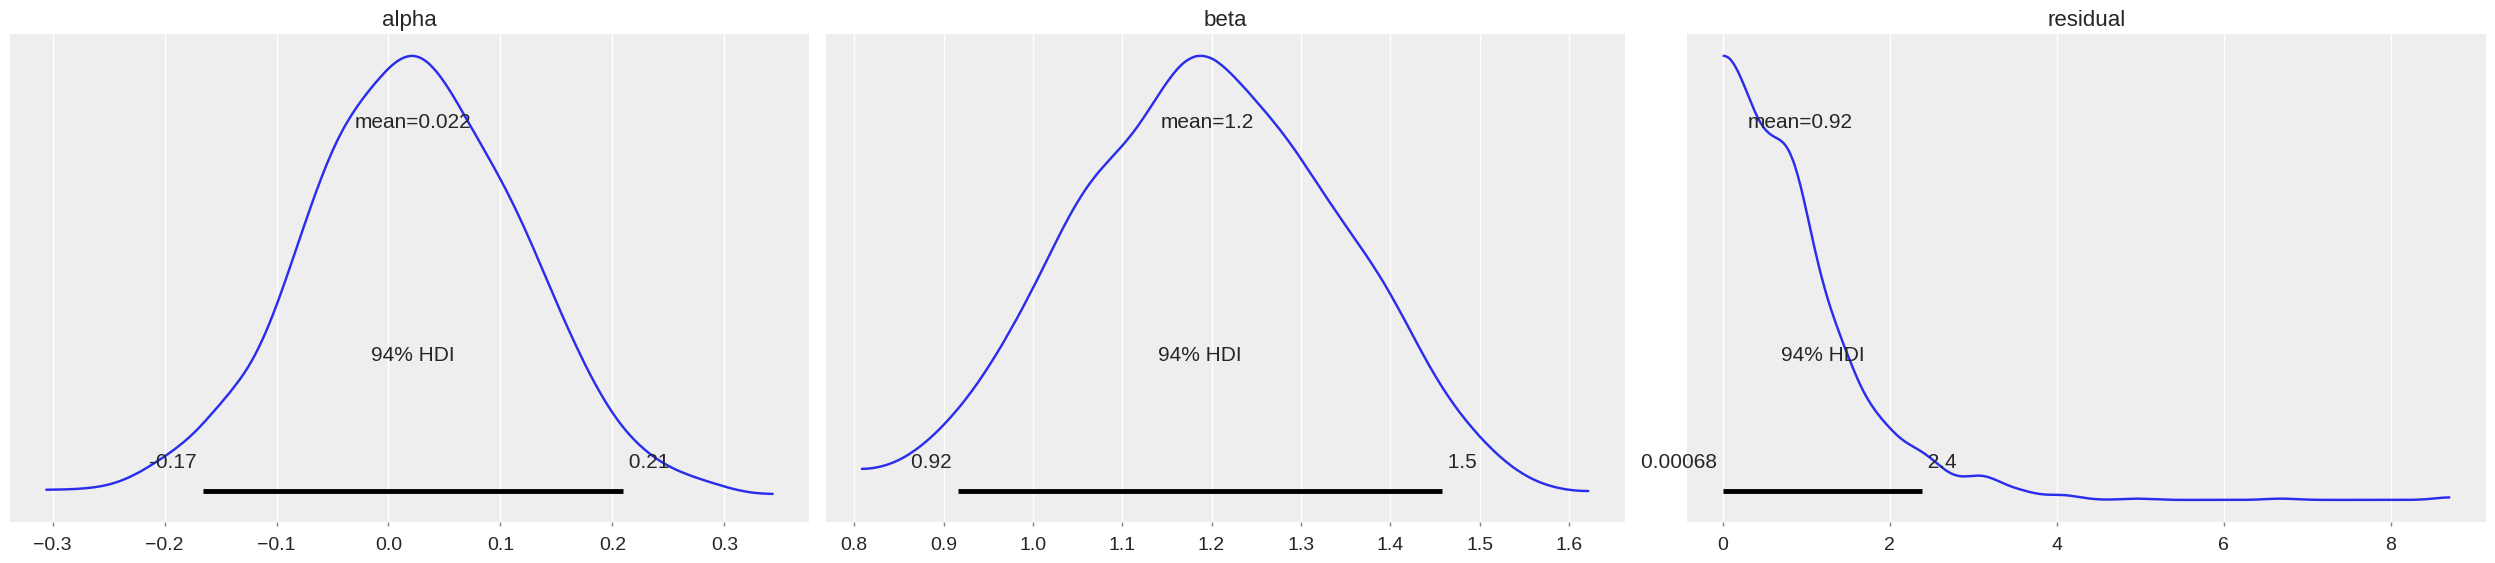

In [ ]:
#Plot the marginal prior distributions of each parameter with 94% highest density intervals
#Note the residual subplot shows the majority of probability density function within 3 percentage points and the rest extending out in a long tail
az.plot_posterior(idata.prior, var_names = ['alpha', 'beta', 'residual'], round_to=2);

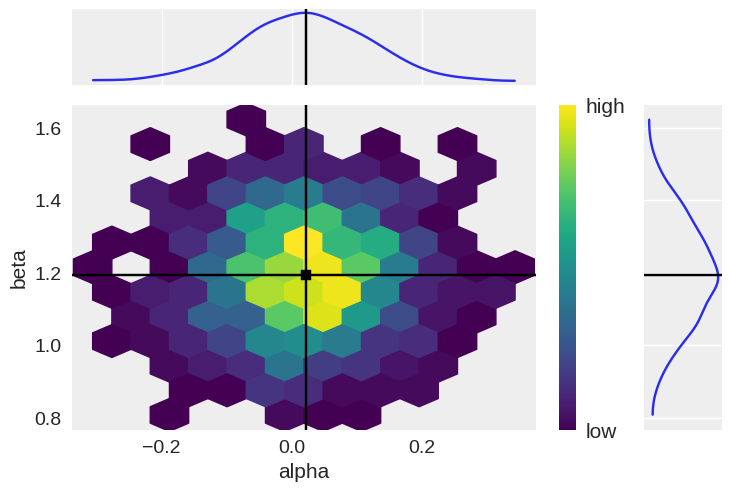

In [ ]:
#Plot the joint prior probability distribution of alpha and beta with their respective means and marginal distributions on the side
#Hexabin plot below shows little or no linear correlation with the high concentration areas in the heat map forming a circle
az.plot_pair(idata.prior, var_names=['alpha', 'beta'], kind='hexbin', marginals=True, point_estimate='mean', colorbar=True);

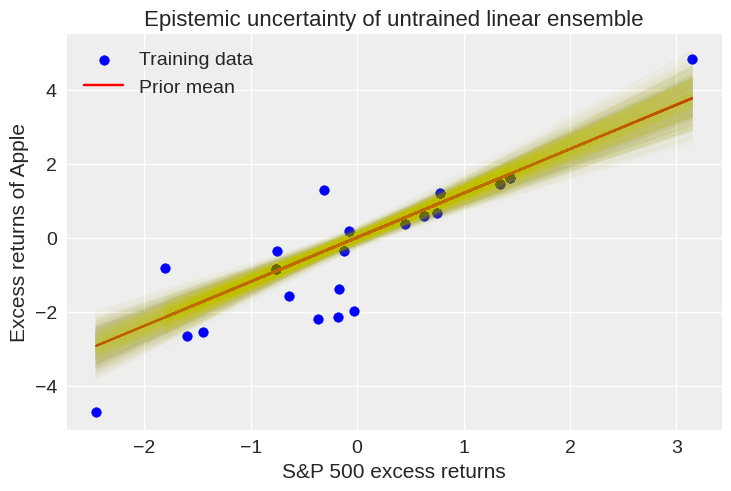

In [ ]:
#Retrieve feature and target training data from the constant_data group
#Feature is now an xarray instead of a Panda's series, a requirement for ArViz data analysis
feature_train = idata.constant_data['feature']
target_train = idata.constant_data['target']

#Generate 1000 linear regression lines based on 1000 draws from one chain of the prior distributions of alpha and beta
#Prior target values are in 1000 arrays with each array having 21 samples, the same number of samples as our training data set
prior_target = idata.prior["alpha"] + idata.prior["beta"] * feature_train

#Since we have 1000 arrays with each array having 21 target values, we have to stack them before we can plot each of them against the 21 feature values
prior_regressions = prior_target.stack(sample=("chain", "draw"))

#We compute the mean of 1000 target values for each of the 21 feature values. So we are averaging across all 1000 regression lines.
#This averaging generates the prior mean regression line which serves as our average prior model
prior_mean_regression = prior_target.mean(("chain", "draw"))

#Create figure of subplots
fig, ax = plt.subplots()

#Plot training data for context
ax.scatter(feature_train, target_train, c='b', label='Training data')

#Plot our expected or average prior model
ax.plot(feature_train, prior_mean_regression, color="r", alpha=1, label='Prior mean')

#Plotting the 1000 regression lines showing us the epistemic uncertainty around the prior mean regression line
ax.plot(feature_train, prior_regressions, c="y", alpha=0.01)

#Label figure
ax.set_xlabel("S&P 500 excess returns")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("Epistemic uncertainty of untrained linear ensemble")
ax.legend();


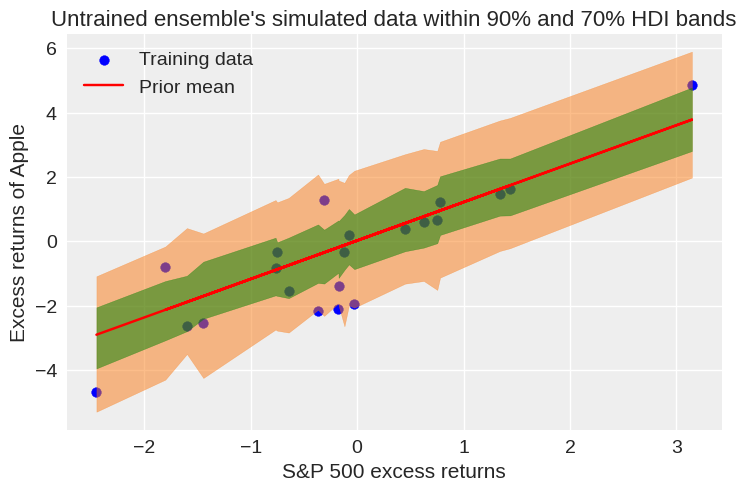

In [ ]:
#Plot the prior predictive distribution of the model before it is trained
#This will show the aleatory and epistemic uncertainty of model output before it is trained
fig, ax = plt.subplots()

#Plot the training data and prior mean regression line for context
ax.scatter(feature_train, idata.observed_data["target_observed"], color='b', label='Training data')
ax.plot(feature_train, prior_mean_regression, color="r", alpha=1,  label='Prior mean')
#Plot the ensemble of 1000 regression lines to show the epistemic uncertainty
#ax.plot(feature_train, prior_regressions, c="y", alpha=0.02)

#Plot the prior predictive data within the two HDI bands to show both epistemic and aleatory uncertainty
az.plot_hdi(feature_train, idata.prior_predictive["target_observed"], hdi_prob=0.90, smooth=False)
az.plot_hdi(feature_train, idata.prior_predictive["target_observed"], hdi_prob=0.70, smooth=False, color='g')

#Label figure
ax.set_xlabel("S&P 500 excess returns")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("Untrained ensemble's simulated data within 90% and 70% HDI bands")
ax.legend();

In [ ]:
#Evaluate untrained ensemble's retrodictions by simulating data it anticipates to see in training

#Extract target values of our training data
target_actual = target_train.values

#Sample the prior predictive distribution to simulate expected target training values
target_expected = idata.prior_predictive.stack(sample=("chain", "draw"))['target_observed'].values.T

#Use the probabilistic R-squared metric
prior_score = az.r2_score(target_actual, target_expected)
prior_score.round(2)

r2        0.61
r2_std    0.10
dtype: float64

In [ ]:
#Use 1000 draws each from two chains or 2000 values of each parameter to analyze the joint posterior distribution
#Check for any divergences in the progress bar. We want 0 divergences for a reliable sampling of the posterior.
idata.extend(pm.sample(draws=1000, chains=2, model=model, random_seed=RANDOM_SEED))


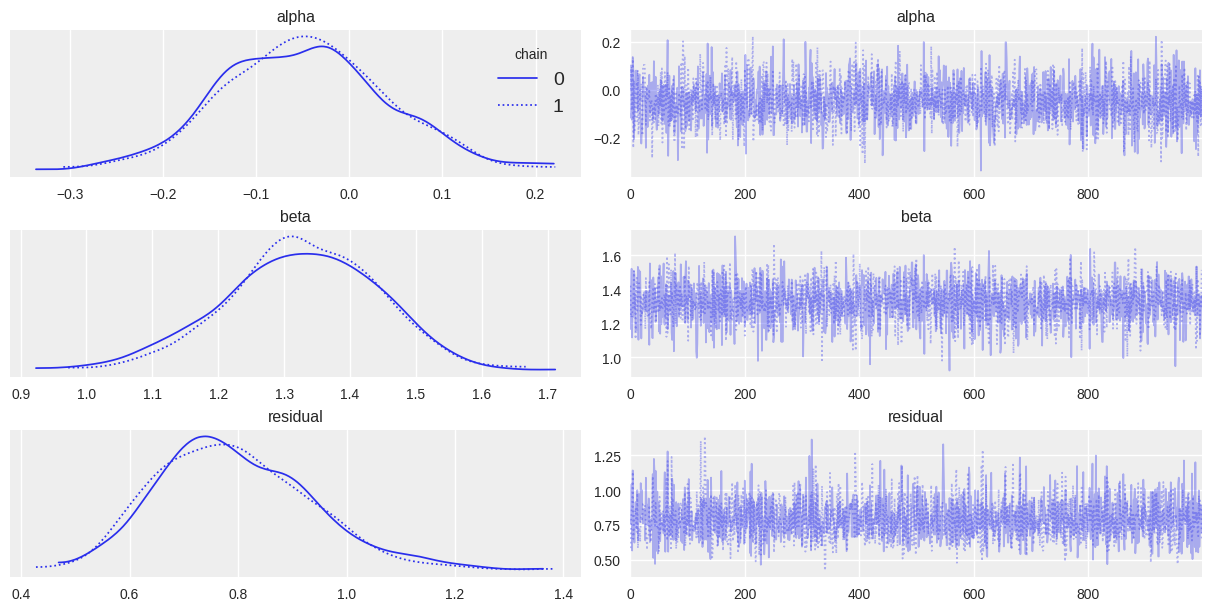

In [ ]:
#Subplots on the left show the kernel density estimates of the marginal posterior probability distributions of each parameter
#The subplots on the right show the actual parameter values that were sampled sequentially in two chains by the PyMC sampling algorithm
with model:
  az.plot_trace(idata.posterior, kind='trace', legend=True)

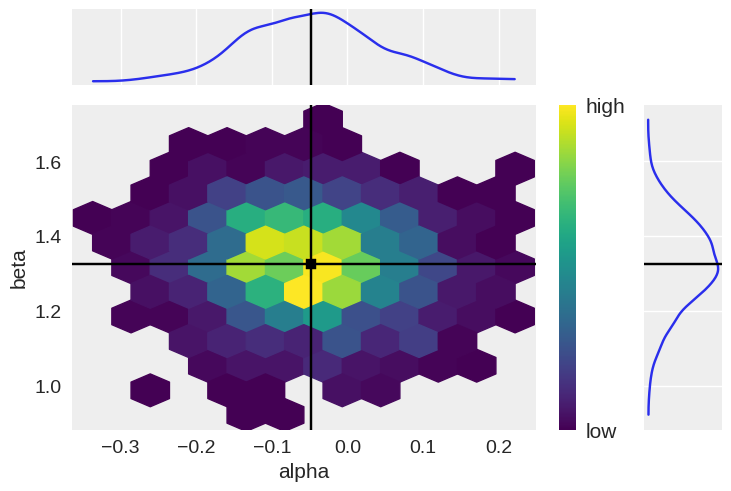

In [ ]:
#Plot the joint posterior probability distribution of alpha and beta with their respective means and marginal distributions on the side
#Hexabin plot below shows little or no linear correlation with the high concentration areas in the heat map forming a circle
az.plot_pair(idata.posterior, var_names=['alpha', 'beta'], kind='hexbin', marginals=True, point_estimate='mean', colorbar=True);

In [ ]:
#Change the default highest density interval to 90%
az.rcParams['stats.hdi_prob'] = 0.90

In [ ]:
#Examine sample statistics of each parameter's posterior marginal distribution, including it's 90% highest density interval (HDI)
display(az.summary(idata, kind='stats', round_to=2))

,mean,sd,hdi_5%,hdi_95%
alpha,-0.05,0.09,-0.19,0.10
beta,1.33,0.12,1.15,1.52
residual,0.79,0.14,0.56,1.00


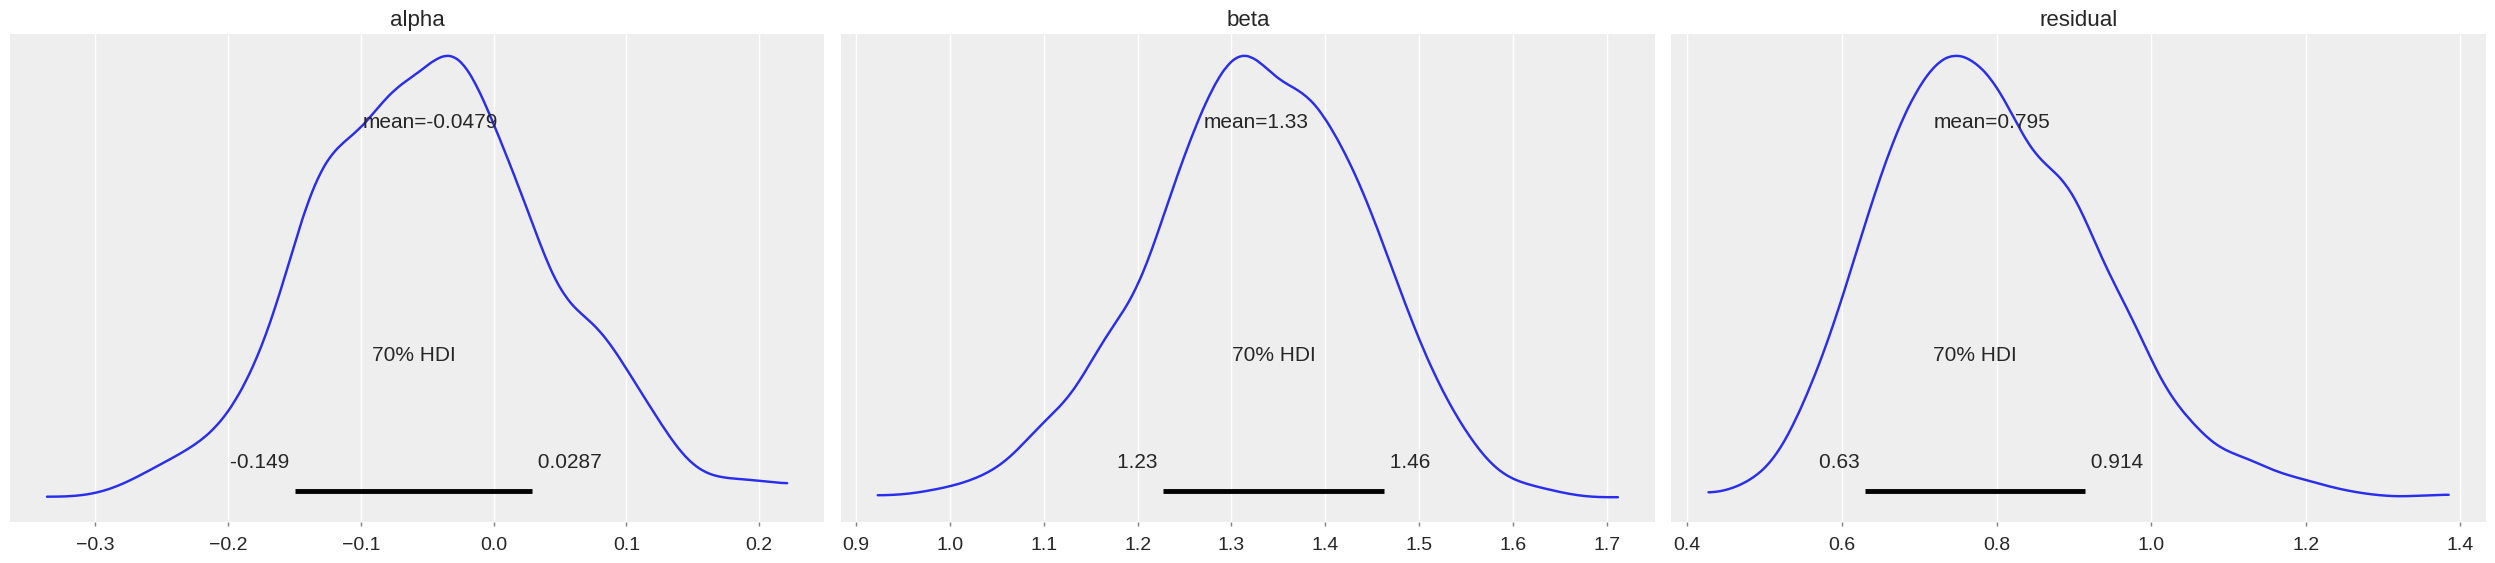

In [ ]:
#Plot the marginal posterior distribution of each parameter displaying the above statistics but now within a 70% HDI
az.plot_posterior(idata, var_names = ['alpha', 'beta', 'residual'], hdi_prob=0.70, round_to=3);

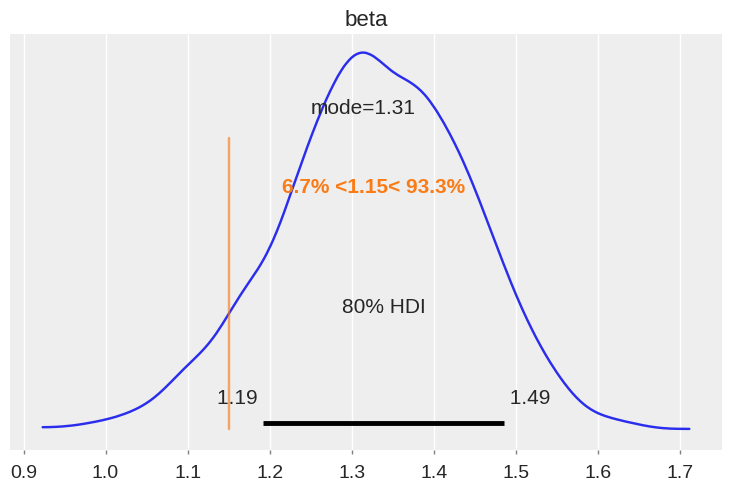

In [ ]:
#Evaluate a point estimate for a single parameter using its posterior distribution
az.plot_posterior(idata, 'beta', ref_val=1.15, hdi_prob=0.80, point_estimate='mode', round_to=3);

In [ ]:
#As a posterior model check, take 1000 draws from the posterior predictive distribution 
with model:
  pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
#Evaluate trained ensemble in-sample retrodictions

#Get target values of our training data
target_actual = target_train.values

#Sample the posterior predictive distribution to simulate expected target training values
target_expected = idata.posterior_predictive.stack(sample=("chain", "draw"))['target_observed'].values.T

#Compute probabilistic R-squared performance metric
training_score = az.r2_score(target_actual, target_expected)
training_score.round(2)

r2        0.65
r2_std    0.08
dtype: float64

In [ ]:
#Now we test our model on out-of-sample or test data. This is the reason we created a mutable data containers earlier
with model:
    #Swap feature and target training data for their respective test data
    pm.set_data({'feature': x_test, 'target': y_test})
    #Create two new inference groups, predictions and predictions_constant_data for making predictions based on features in the test data
    pm.sample_posterior_predictive(idata, return_inferencedata=True, predictions=True, extend_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
#Get feature and target test data
feature_test = idata.predictions_constant_data['feature']
target_test = idata.predictions_constant_data['target']

#Generate 2000 linear regression lines based on 1000 draws each from two chains of the posterior distributions of alpha and beta
#Posterior target values are in 2000 arrays, each with 21 samples of target values, the same number of samples as our training data set
posterior = idata.posterior

#Predict target values based on posterior values of regression parameters and feature test data
prediction_target = posterior["alpha"] + posterior["beta"] * feature_test

#Stack ensemble of regression lines
predicted_regressions = prediction_target.stack(sample=("chain", "draw"))

#Compute the predicted mean regression line
predicted_mean_regression = prediction_target.mean(("chain", "draw"))


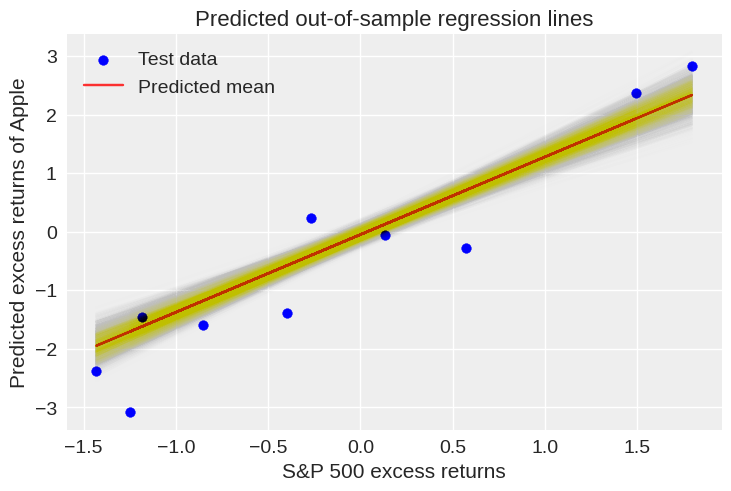

In [ ]:
#Create figure of subplots
fig, ax = plt.subplots()

#Plot test data for context
ax.scatter(feature_test, target_test, c='b', label='Test data')

#Plot expect posterior model
ax.plot(feature_test, predicted_mean_regression, color="r", alpha=0.8, label='Predicted mean')

#Plotting the 2000 regression lines showing the epistemic uncertainty around the posterior mean regression line
ax.plot(feature_test, predicted_regressions, c="y", alpha=0.005)

#Label figure
ax.set_xlabel("S&P 500 excess returns")
ax.set_ylabel("Predicted excess returns of Apple")
ax.set_title("Predicted out-of-sample regression lines")
ax.legend();

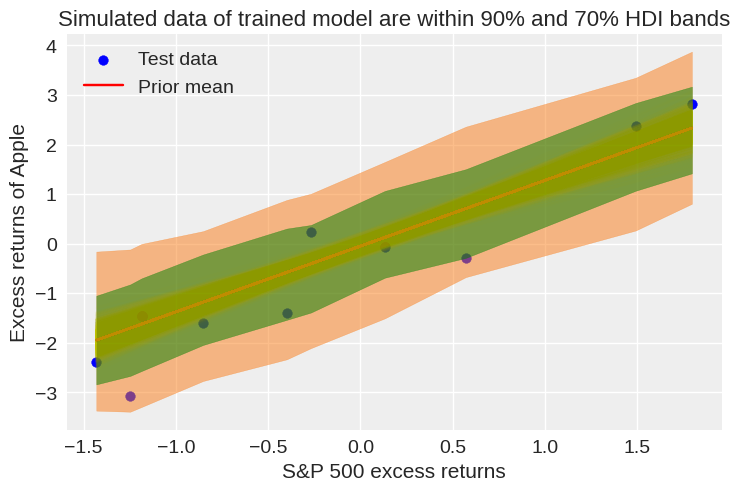

In [ ]:
#Plot the predictions of the model after it is trained
#This will show the aleatory and epistemic uncertainties of model's output after it is trained
fig, ax = plt.subplots()

#Plot the training data and prior mean regression line for context
ax.scatter(feature_test, target_test, color='b', label='Test data')
ax.plot(feature_test, predicted_mean_regression, color="r", alpha=1,  label='Prior mean')
#Plot the ensemble of 2000 regression lines displaying epistemic uncertainty
ax.plot(feature_test, predicted_regressions, c="y", alpha=0.02)

#Plot the posterior predictive data within the two HDI bands to show both epistemic and aleatory uncertainties
az.plot_hdi(feature_test, idata.predictions["target_observed"], hdi_prob=0.90, smooth=False)
az.plot_hdi(feature_test, idata.predictions["target_observed"], hdi_prob=0.70, smooth=False, color='g')

#Label figure
ax.set_xlabel("S&P 500 excess returns")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("Simulated data of trained model are within 90% and 70% HDI bands")
ax.legend();

In [ ]:
#Evaluate out-of-sample predictions of trained ensemble

#Get target values of our test data
target_actual = target_test.values

#Sample ensemble's predictions of target test/ out-of-sample values
target_expected = idata.predictions.stack(sample=("chain", "draw"))['target_observed'].values.T

#Compute the probabilistic R-squared performance metric
test_score = az.r2_score(target_actual, target_expected)
test_score.round(2)

r2        0.69
r2_std    0.13
dtype: float64